### Курсовой проект для курса "Python для Data Science"
### Aleksey - Ushakov 

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)
Вспомогательная метрика: MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.

### Последовательность действий


1. Ручная обработка данных тренировочного и тестового датасетов (работа с аномальными значениями)
2. Автоматическая обработка данных тренировочного и тестового датасетов
2. Построение модели линейной регрессии + проверка
3. Построение модели на базе RandomForestRegressor + проверка
4. Выгрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import catboost as catb

from sklearn.model_selection import train_test_split # функция разделения массива данных на тренировочные и тестовые
from sklearn.model_selection import StratifiedKFold # функция разделения массива данных на тренировочные и тестовые
from sklearn.model_selection import GridSearchCV # класс для тестирования различных параметров на модели

from sklearn.linear_model import LinearRegression # загрузка класс linear regression
from sklearn.linear_model import Lasso # загрузка класс linear regression
from sklearn.linear_model import Ridge # загрузка класс linear regression

from sklearn.ensemble import RandomForestRegressor # загрузка класс linear regression
from sklearn.ensemble import RandomForestClassifier # загрузка класс linear regression
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error # среднеквадратичное отклонение
from sklearn.metrics import mean_absolute_error # среднее абсолютное отклонение
from sklearn.metrics import r2_score # Метрика R^2

from sklearn.preprocessing import StandardScaler #класс для стандартизации признаков
from sklearn.preprocessing import RobustScaler #класс для масштабирования признаков

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 500)
plt.style.use('fivethirtyeight')

%config inlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# Функция для визуализации модели
def visualize_model(y_facts, y_preds, model_fetures):    
    
    model_results = pd.DataFrame({'y_facts':y_facts, 'y_preds':y_preds, 'y_error':y_facts - y_preds}, index=y_facts.index)
    
    fig, ax = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(17,9)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    ax = ax.flatten()
    
    ax[0].plot(range(y_facts.count()), model_results.sort_values(by='y_preds')['y_error'], label='y_error', color='grey')
    ax[0].scatter(range(y_facts.count()), model_results.sort_values(by='y_preds')['y_facts'], label='y_facts', s=2, color='blue')
    ax[0].plot(range(y_facts.count()), model_results.sort_values(by='y_preds')['y_preds'], label='y_preds', color='red',linewidth=5)

    ax[0].plot(range(y_facts.count()), np.zeros(y_valid.count()), label='0', color='black')
    ax[0].legend()
    ax[1].barh(model_fetures.sort_values(by='Coef')['Features'], model_fetures.sort_values(by='Coef')['Coef'])

In [3]:
# Функция для определения HouseYear_period
def HouseYear_period(HouseYear):
    #HouseYear_periods = np.linspace(data['HouseYear'].min(), data['HouseYear'].max(),11).round().astype(int) 
    HouseYear_periods = [1900, 1920, 1932, 1954, 1965, 1987, 1998, 2009, 2018, 2030]
    for i in range(len(HouseYear_periods)-1):
        if HouseYear >= HouseYear_periods[i] and HouseYear <= HouseYear_periods[i+1]:
            return (str(HouseYear_periods[i]) + ' - ' +  str(HouseYear_periods[i+1]))

In [4]:
# Функция для автоматической чистки данных
def data_preparation(df_with_test_data, df_with_statistic_data):
    df_test = df_with_test_data.copy()
    df_stat = df_with_statistic_data.copy()

# Square - замена выбросов наблюдений (170м < Square < 21м) на оптимальные значения
    df_test.loc[df_test['Square'] < 21,'Square'] = 48
    df_test.loc[df_test['Square'] > 170,'Square'] = 85
    
    df_stat.loc[df_stat['Square'] < 21,'Square'] = 48
    df_stat.loc[df_stat['Square'] > 170,'Square'] = 85
    
# KitchenSquare - замена площади меньшей чем 5 и большей чем (общая площадь квартиры - 8) на среднее значение
    mean_kitchen = round(df_stat.loc[(df_stat['KitchenSquare']>4) & 
                                            (df_stat['Square'] - df_stat['KitchenSquare'] > 8),
                                            'KitchenSquare'].mean())
    df_test.loc[(df_test['Square'] - df_test['KitchenSquare'] < 8) | 
                  (df_test['KitchenSquare']<5),'KitchenSquare'] = mean_kitchen    
    
# lifeSquare - замена Аномальных значений
    df_test.loc[(df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'] - 5 < 0) |
                (df_test['LifeSquare'].isnull()) | 
                ((df_test['LifeSquare']<10) & (df_test['Square']>30)),
                'LifeSquare'] = df_test['Square'] - df_test['KitchenSquare'] - 5

# Healthcare_1 - замена пустых значений на моду (сначала заменяются на моды по району, а если такой нет то на моду по датасету)
    df_test.loc[df_test['Healthcare_1'].isnull(),'Healthcare_1'] = df_stat['Healthcare_1'].mode()[0]
    
# Floor & HouseFloor - на цену влияет принадлежность квартиры к первому и последнему этажу
    df_test.loc[df_test['HouseFloor'] < df_test['Floor'],'HouseFloor'] = df_test['Floor'] + 1
# добавление фактической стоимости метра квадратного в стат датасет
    df_stat['M_Price'] = df_stat['Price'] / df_stat['Square']

# добавляем среднюю стоимость метра квадратного в районе в зависимости от комнатности квартиры    

    ditrict_f = df_stat['DistrictId'].value_counts()
    df_stat_major_districts = df_stat.loc[df_stat['DistrictId'].isin(ditrict_f[ditrict_f>100].index),:]
    df_stat_minor_districts =  df_stat.loc[~df_stat['DistrictId'].isin(ditrict_f[ditrict_f>100].index),:]
    # По основным районам
    m_price_by_dist = df_stat_major_districts.groupby(['DistrictId','Rooms'])['M_Price'].mean().reset_index()
    m_price_by_dist = m_price_by_dist.rename(columns={'M_Price':'M_Price_mean'})
    df_test = pd.merge(df_test, m_price_by_dist, how='left',on=['DistrictId','Rooms'])
    # По второстепенным районам    
    m_price_by_dist = df_stat_minor_districts.groupby(['DistrictId'])['M_Price'].mean().reset_index()    
    m_price_by_dist = m_price_by_dist.rename(columns={'M_Price':'M_Price_mean+'})
    df_test = pd.merge(df_test, m_price_by_dist, how='left',on=['DistrictId'])     
    df_test.loc[df_test['M_Price_mean'].isnull(),'M_Price_mean'] = df_test['M_Price_mean+']
    df_test = df_test.drop(['M_Price_mean+'],axis=1)
    # По районам которые были в тестовой выборке но было в тренировочной (или было меньше 3 раз)
    df_test.loc[df_test['M_Price_mean'].isnull(),'M_Price_mean'] = df_stat['M_Price'].mean()
    df_test.loc[df_test['DistrictId'].isin(ditrict_f[ditrict_f<3].index),'M_Price_mean'] = df_stat['M_Price'].mean()

# Lобавление оценки стоимости квартиры
    df_test['Price_mean'] = df_test['M_Price_mean'] * df_test['Square']
# HousePeriod - Распределение квартир по периодам застройки
    df_test['HousePeriod'] = df_test['HouseYear'].apply(lambda x: HouseYear_period(x))    
# Dummy переменные - вручную (автоматом добавляет 2 переменные, а вручную - 1)    
    df_test.loc[df_test['Ecology_2'] =='A', 'Ecology_2'] = 1
    df_test.loc[df_test['Ecology_2'] =='B', 'Ecology_2'] = 0
    df_test.loc[df_test['Ecology_3'] =='A', 'Ecology_3'] = 1
    df_test.loc[df_test['Ecology_3'] =='B', 'Ecology_3'] = 0
    df_test.loc[df_test['Shops_2'] =='A', 'Shops_2'] = 1
    df_test.loc[df_test['Shops_2'] =='B', 'Shops_2'] = 0
# Dummy переменные автоматом
    df_test['Helthcare_2'] = df_test['Helthcare_2'].astype('category')
    df_test = pd.get_dummies(df_test)
# Степени переменных
    df_test['k1'] = df_test['Square'] ** 2
    df_test['k2'] = (df_test['Square'] / df_test['LifeSquare']) ** 2
    df_test['k3'] = 1 / df_test['Square']
    df_test['k4'] = 1 / df_test['M_Price_mean']

# Эксперементальные переменные:
    df_test['7f_building'] = 0
    df_test.loc[df_test['HouseFloor'] <= 7,'7f_building'] = df_test['Price_mean']
    df_test['first_floor'] = 0
    df_test.loc[(df_test['Floor'] == 1) ,'first_floor'] = df_test['Price_mean']   
    df_test['last_floor'] = 0
    df_test.loc[(df_test['Floor'] == df_test['HouseFloor']) ,'last_floor'] = df_test['Price_mean'] 
    df_test['High_floor'] = 0
    df_test.loc[(df_test['Floor'] > 11) & (df_test['last_floor'] != 1) ,'High_floor'] = df_test['Price_mean']

# Установка Id как индекса
    df_test = df_test.set_index(df_test['Id']).drop('Id', axis=1) 
    
    return df_test

In [5]:
# Загрузка входных данных
test_data = pd.read_csv('D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience/Pjt/test.csv')
labled_data = pd.read_csv('D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience/Pjt/train.csv')

### Ручная обработка аномальных данных тестового Dataset

In [6]:
# Rooms
test_data.loc[test_data['Id'].isin([3343]),'Rooms'] = 5
test_data.loc[test_data['Id'].isin([10793, 15858]),'Rooms'] = 4
test_data.loc[test_data['Id'].isin([10729, 10419, 10734, 7135, 13366, 16217, 4545, 555, 2549, 12959, 6967, 4509, 7064, 16079, 3512, 11487, 16261, 265]),'Rooms'] = 3
test_data.loc[test_data['Id'].isin([1435, 6060]),'Rooms'] = 2
test_data.loc[test_data['Id'].isin([11407]),'Rooms'] = 1
# HouseYear - ok
# Square
test_data.loc[test_data['Id'].isin([170]),'Square'] = test_data['LifeSquare']
# Floor
test_data.loc[test_data['Id'].isin([15759]),'Floor'] = 18
# HouseFloor
test_data.loc[test_data['Id'].isin([15864]),'HouseFloor'] = 22

### Ручная обработка аномальных данных тренировочного Dataset

In [7]:
# Rooms
labled_data.loc[labled_data['Id'].isin([7917]),'Rooms'] = 5
labled_data.loc[labled_data['Id'].isin([12638]),'Rooms'] = 4
labled_data.loc[labled_data['Id'].isin([456, 9443, 7135, 3281, 1779, 2217, 135, 3771, 967, 2252, 1916, 2754, 1687, 878, 4074, 1727, 553, 1475, 2890, 1853]),'Rooms'] = 3
labled_data.loc[labled_data['Id'].isin([5927, 14003, 14865, 770]),'Rooms'] = 2
labled_data.loc[labled_data['Id'].isin([8491, 7594, 6358, 7317, 3159, 3224]),'Rooms'] = 1
# Square
labled_data.loc[labled_data['Id'].isin([28, 11602, 2307]),'Square'] = labled_data['Square'] / 10
labled_data.loc[labled_data['Id'].isin([10527, 13265, 1748]),'Square'] = labled_data['LifeSquare']
# HouseYear
labled_data.loc[labled_data['HouseYear'] == 4968,'HouseYear'] = 1968
labled_data.loc[labled_data['HouseYear'] == 20052011,'HouseYear'] = 2008
# Floor & HouseFloor - на цену влияет принадлежность квартиры к первому и последнему этажу
labled_data.loc[labled_data['Id'].isin([9300,10806]),'HouseFloor'] = 9
labled_data.loc[labled_data['Id'].isin([78]),'HouseFloor'] = 17

### Модель Линейной регрессии

In [13]:
# Функция преобразование данных для работы LR модели
def lr_model_inputs (df_input, scaler_dataset):
    # Колонки для стандартизации входных параметров
    scaler_columns = ['Rooms', 'Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Shops_1', 'Shops_2',
            'Ecology_1','Ecology_2', 'Ecology_3','Social_1','Social_2','Social_3','Healthcare_1','Shops_1',
            'M_Price_mean','Price_mean','k1','k2','k3','k4', '7f_building', 'first_floor', 'last_floor',
            'Healthcare_1', 'Helthcare_2_0','Helthcare_2_1', 'Helthcare_2_2', 'Helthcare_2_3','Helthcare_2_4','Helthcare_2_5','Helthcare_2_6']
    
    df = df_input.copy()
    scaler = StandardScaler()
    scaler.fit(scaler_dataset[scaler_columns])
    df[scaler_columns] = scaler.transform(df[scaler_columns])
    df = df.drop(['DistrictId', 'M_Price_mean'], axis=1)
    df = df.drop(['HouseYear'], axis=1)    
    df = df.drop(['Shops_1', 'Shops_2'], axis=1)
    df = df.drop(['Ecology_2', 'Ecology_3'], axis=1)
    df = df.drop(['Social_1', 'Social_2', 'Social_3'], axis=1)
    df = df.drop(['Helthcare_2_1', 'Helthcare_2_2', 'Helthcare_2_4','Helthcare_2_5','Helthcare_2_6'], axis=1)
    #df = df.drop(['Rooms'], axis=1) #Best model    
    #df = df.drop(['Floor'], axis=1) #Best model
    #df = df.drop(['HouseFloor'], axis=1) #Best model    
    #df = df.drop(['KitchenSquare'], axis=1) #Best model
    #df = df.drop(['LifeSquare'], axis=1) #Best model
    #df = df.drop(['7f_building'], axis=1) #Best model
    #df = df.drop(['Healthcare_1'], axis=1) #Best model
    #df = df.drop(['Helthcare_2_0', 'Helthcare_2_3'], axis=1) #Best model
    #df = df.drop(['k1', 'k2', 'k3', 'k4'], axis=1) #Best model
    
    return df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


Валидационный Dataset r2: 0.7492157913592479
Тренировочный Dataset r2: 0.7287262806975732


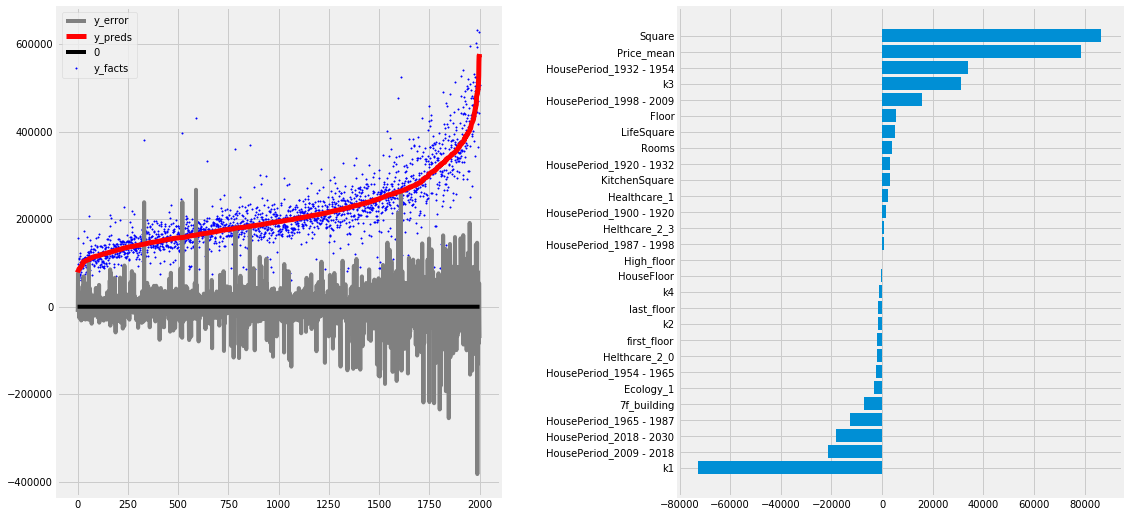

In [14]:
# Деление train_data на тестовые и тренировочные, затем тренировочный делится еще раз на тренировочный и валидационный
lr_train_data, lr_valid_data = train_test_split(labled_data, test_size=0.2, random_state=23348) #681, 5509, 23348
# Автоматическая обработка данных

# Обработка данных для модели
lr_train_data_processed = data_preparation(lr_train_data, lr_train_data)
X_train = lr_model_inputs(lr_train_data_processed.drop(['Price'], axis=1), lr_train_data_processed)
y_train = lr_train_data_processed['Price']

lr_valid_data_processed = data_preparation(lr_valid_data, lr_train_data)
X_valid = lr_model_inputs(lr_valid_data_processed.drop(['Price'], axis=1), lr_train_data_processed)
y_valid = lr_valid_data_processed['Price']

# Обучение модели
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Построение пронозов
y_train_pred = lr_model.predict(X_train)
y_valid_pred = lr_model.predict(X_valid)

# Вывод метрик модели на различных датасетах
print('Валидационный Dataset r2:', r2_score(y_valid, y_valid_pred))
print('Тренировочный Dataset r2:', r2_score(y_train, y_train_pred))

# Визуализация модели
visualize_model(y_valid, y_valid_pred, pd.DataFrame({'Features': X_valid.columns, 'Coef':lr_model.coef_.flatten()}))

### Модель RandomForestRegression

In [15]:
# Преобразование данных для работы RFR модели
def rfr_model_inputs(df_input):
    df = df_input.copy()
    df = df.drop(['DistrictId'], axis=1)
    #df = df.drop(['M_Price_mean'], axis=1)
    #df = df.drop(['LifeSquare'], axis=1)
    #df = df.drop(['Rooms'], axis=1)
    #df = df.drop(['HouseYear'], axis=1)
    #df = df.drop(['Shops_1'], axis=1)
    #df = df.drop(['Shops_2'], axis=1)
    #df = df.drop(['Ecology_2'], axis=1)
    #df = df.drop(['Ecology_3'], axis=1)
    #df = df.drop(['Social_1'], axis=1)
    #df = df.drop(['Social_2'], axis=1)
    #df = df.drop(['Social_3'], axis=1)
    #df = df.drop(['Healthcare_1'], axis=1)
    #df = df.drop(['Helthcare_2_1', 'Helthcare_2_2', 'Helthcare_2_4','Helthcare_2_5','Helthcare_2_6',], axis=1)
    
    return df

In [16]:
# Деление train_data на тестовые и тренировочные, затем тренировочный делится еще раз на тренировочный и валидационный
rfr_train_data, rfr_valid_data = train_test_split(labled_data, test_size=0.2, random_state=23348) #681, 5509, 23348

# Обработка данных для модели
rfr_train_data_processed = data_preparation(rfr_train_data, rfr_train_data)
X_train = rfr_model_inputs(rfr_train_data_processed.drop(['Price'], axis=1))
y_train = rfr_train_data_processed['Price']

rfr_valid_data_processed = data_preparation(rfr_valid_data, rfr_train_data)
X_valid = rfr_model_inputs(rfr_valid_data_processed.drop(['Price'], axis=1))
y_valid = rfr_valid_data_processed['Price']

In [17]:
# Определение оптимальных параметров модели
parameters =  [{'n_estimators': [100], 'max_features': [5], 'max_depth': [15], 'random_state':[42]}]
#parameters =  [{'n_estimators': [50, 75, 100, 150, 200], 'max_features': [4, 5], 'max_depth': [15], 'random_state':[42]}]
GSCV_models = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters, scoring='r2', cv=3)
GSCV_models.fit(X_train, y_train)
GSCV_models.best_params_

{'max_depth': 15, 'max_features': 5, 'n_estimators': 100, 'random_state': 42}

In [18]:
# Постороение модели на базе оптимальных параметров
rfr_model = RandomForestRegressor(n_estimators = GSCV_models.best_params_['n_estimators'],
                                  max_depth=GSCV_models.best_params_['max_depth'],
                                  max_features=GSCV_models.best_params_['max_features'],
                                  random_state = GSCV_models.best_params_['random_state'])
#rfr_model = RandomForestRegressor(n_estimators = 150, max_depth=14, max_features=4, random_state=1)

# Обучение модели
rfr_model.fit(X_train, y_train)

# Построение пронозов
y_train_pred = rfr_model.predict(X_train)
y_valid_pred = rfr_model.predict(X_valid)

# Формирование массива включающего все train данные для проверки модели
check_data = pd.concat([rfr_train_data_processed.reset_index(), pd.DataFrame({'Price_pred':y_train_pred})], axis=1)
check_data['price_error'] = (check_data['Price'] - check_data['Price_pred'])
check_data['price_error_rate'] = (check_data['price_error'] / check_data['Price'])
# Классификация пронозов с большими отклонениями от фактических данных
check_data['high_error'] = 0
check_data.loc[check_data['price_error_rate']<-0.5, 'high_error'] = 1
check_train_data = check_data

print(check_train_data.loc[check_data['high_error']==1, 'high_error'].count())


# Формирование массива включающего все valid данные модели
check_data = pd.concat([rfr_valid_data_processed.reset_index(), pd.DataFrame({'Price_pred':y_valid_pred})], axis=1)
check_data['price_error'] = (check_data['Price'] - check_data['Price_pred'])
check_data['price_error_rate'] = (check_data['price_error'] / check_data['Price'])
check_valid_data = check_data

# Обучение модели классифицировать предсказания с большими отклонениями от реальности
scaler = StandardScaler()
scaler.fit(check_train_data.drop(['Price','price_error','price_error_rate','high_error',] ,axis=1))

rfc_model = RandomForestClassifier(n_estimators = 30)
rfc_model.fit(scaler.transform(check_train_data.drop(['Price','price_error','price_error_rate','high_error',] ,axis=1)),check_train_data['high_error'])

check_valid_data['high_error'] = rfc_model.predict(scaler.transform(check_valid_data.drop(['Price','price_error','price_error_rate'],axis=1)))
print('rfc_model', check_valid_data.loc[check_valid_data['high_error']==1, 'high_error'].count())


svc_model = SVC(gamma='auto')
svc_model.fit(scaler.transform(check_train_data.drop(['Price','price_error','price_error_rate','high_error',] ,axis=1)),check_train_data['high_error'])
check_valid_data['high_error'] = svc_model.predict(scaler.transform(check_valid_data.drop(['Price','price_error','price_error_rate','high_error'],axis=1)))
print('svc_model', check_valid_data.loc[check_valid_data['high_error']==1, 'high_error'].count())

#Корректировка данных с большим отклонением от предсказаний
check_valid_data.loc[check_valid_data['high_error']==1,'Price_pred'] = check_valid_data['Price_pred'] / 1.5


187


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


rfc_model 0
svc_model 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


Валидационный Dataset r2: 0.7790084699858765
Тренировочный Dataset r2: 0.9358039116085903


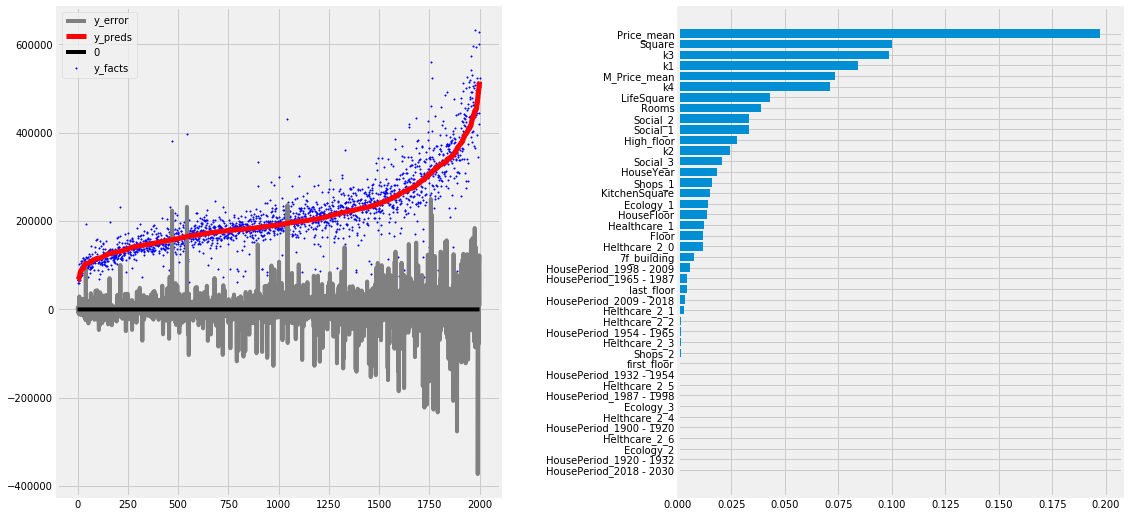

In [19]:
# Метрик модели на различных датасетах
print('Валидационный Dataset r2:', r2_score(y_valid, check_valid_data['Price_pred']))
print('Тренировочный Dataset r2:', r2_score(y_train, y_train_pred))

# Визуализация модели
visualize_model(check_valid_data['Price'] , check_valid_data['Price_pred'] , pd.DataFrame({'Features': X_valid.columns, 'Coef':rfr_model.feature_importances_.flatten()}))

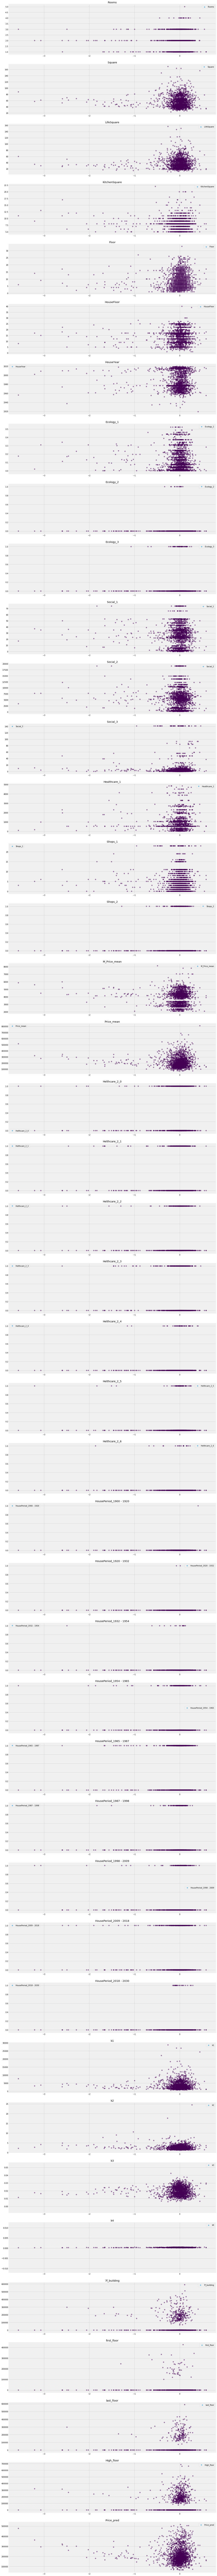

In [20]:


metrics = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Shops_1', 'Shops_2', 'M_Price_mean', 'Price_mean',
       'Helthcare_2_0', 'Helthcare_2_1', 'Helthcare_2_2', 'Helthcare_2_3',
       'Helthcare_2_4', 'Helthcare_2_5', 'Helthcare_2_6',
       'HousePeriod_1900 - 1920', 'HousePeriod_1920 - 1932',
       'HousePeriod_1932 - 1954', 'HousePeriod_1954 - 1965',
       'HousePeriod_1965 - 1987', 'HousePeriod_1987 - 1998',
       'HousePeriod_1998 - 2009', 'HousePeriod_2009 - 2018',
       'HousePeriod_2018 - 2030', 'k1', 'k2', 'k3', 'k4', '7f_building',
       'first_floor', 'last_floor', 'High_floor', 'Price_pred']

fig, ax = plt.subplots(nrows=len(metrics),ncols=1)
fig.set_size_inches(18,len(ax)*6)
ax = ax.flatten()

for i in range(len(ax)):
    ax[i].scatter(check_valid_data.loc[check_valid_data['price_error_rate']<10,'price_error_rate'],
                  check_valid_data.loc[check_valid_data['price_error_rate']<10,metrics[i]],
                  c=check_valid_data.loc[check_valid_data['price_error_rate']<10,'high_error'],
                  label=metrics[i], alpha=0.5)
    ax[i].legend()
    ax[i].set_title(metrics[i])

### Выгрузка рузультатов работы с тестовым массивом

In [21]:
#Проверка работы LR модели:
lr_test_data = test_data
# Автоматическая обработка данных
lr_test_data_processed = data_preparation(lr_test_data, labled_data)
# Формирование данных для модели
X_test = lr_model_inputs(lr_test_data_processed, lr_train_data_processed)
#X_test = lr_model_inputs(lr_test_data_processed.drop(['Price'], axis=1), lr_train_data_processed)
#y_test = lr_test_data_processed['Price']

# Построение пронозов
y_test_pred = lr_model.predict(X_test)
#print('LR модель r2: ', r2_score(y_test, y_test_pred))
pd.DataFrame({'Id':X_test.index, 'Price':y_test_pred}).to_csv('AUshakov_predictions_lr.csv', index=False)
print('Прогноз lr модели выгружен в файл AUshakov_predictions_lr.csv')

#Проверка работы RFR модели:
rfr_test_data = test_data
# Автоматическая обработка данных
rfr_test_data_processed = data_preparation(rfr_test_data, labled_data)
X_test = rfr_model_inputs(rfr_test_data_processed)
#X_test = rfr_model_inputs(rfr_test_data_processed.drop(['Price'], axis=1))
#y_test = rfr_test_data_processed['Price']

# Построение прогнозов
#y_test_pred = rfr_model.predict(X_test)

#print('RFR модель r2: ', r2_score(y_test, y_test_pred))
pd.DataFrame({'Id':X_test.index, 'Price':y_test_pred}).to_csv('AUshakov_predictions.csv', index=False)
print('Прогноз rf модели выгружен в файл AUshakov_predictions.csv')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


Прогноз lr модели выгружен в файл AUshakov_predictions_lr.csv
Прогноз rf модели выгружен в файл AUshakov_predictions.csv


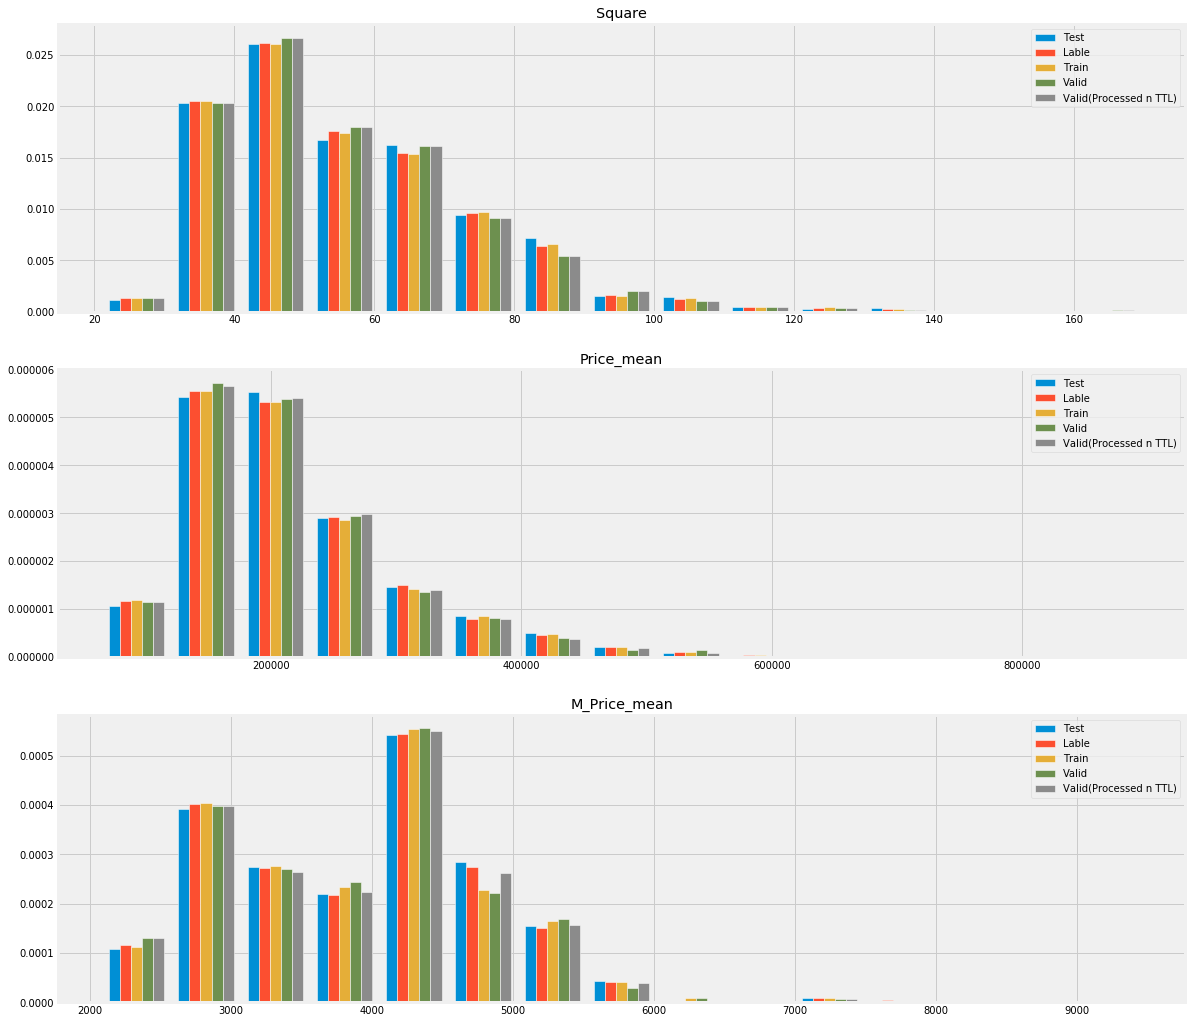

In [22]:
# Проверка распределения основных признаках на тестовой, полной, валидационной и валидационной с обработкой с помощью полных данных
labled_data_processed = data_preparation(labled_data, labled_data)

metrics = ['Square', 'Price_mean', 'M_Price_mean']

fig, ax = plt.subplots(nrows=len(metrics),ncols=1)
fig.set_size_inches(18,len(ax)*6)

test_data_processed = data_preparation(test_data, labled_data)
rfr_valid_data_processed_ = data_preparation(rfr_valid_data, labled_data)

ax = ax.flatten()

for i in range(len(ax)):
    ax[i].hist([test_data_processed[metrics[i]], 
            labled_data_processed[metrics[i]], 
            rfr_train_data_processed[metrics[i]],
            rfr_valid_data_processed[metrics[i]],
            rfr_valid_data_processed_[metrics[i]]], bins=15, ec='white', density=True, label=['Test','Lable','Train','Valid','Valid(Processed n TTL)'])
    ax[i].legend()
    ax[i].set_title(metrics[i])